In [26]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [42]:
# 1) Load a built-in time series dataset (weekly CO2), clean, and set frequency
df = sm.datasets.co2.load_pandas().data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [43]:
df.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

In [44]:
y = df["co2"].asfreq("W-SAT")          # ensure regular weekly frequency
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Series name: co2
Non-Null Count  Dtype  
--------------  -----  
2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


In [45]:
# fill missing values (simple, common baseline)
y = y.interpolate()         
# y1 = y.fillna(method="ffill")          # step-function fill
# y2 = y.fillna(method="bfill")
# y3 = y.fillna(y.median())              # constant fill           

method="linear" (default): linearly interpolates by position (row number) unless you use time-aware settings.

method="time": interpolates using the DatetimeIndex spacing (good if your time index is irregular).

limit, limit_direction: cap how many consecutive NaNs you fill.

In [46]:
print("Start/End:", y.index.min(), y.index.max())
print("N:", len(y), "Missing:", y.isna().sum())

Start/End: 1958-03-29 00:00:00 2001-12-29 00:00:00
N: 2284 Missing: 0


In [47]:
# 2) Quick summary stats (often asked)
y.describe()

count    2284.000000
mean      339.652496
std        17.103561
min       313.000000
25%       323.975000
50%       337.700000
75%       354.500000
max       373.900000
Name: co2, dtype: float64

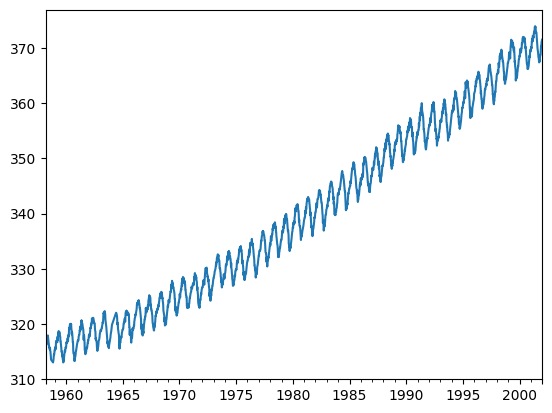

In [48]:
y.plot()
plt.show()

In [49]:
# 5) Train/test split (time-ordered; no shuffle)
split = int(len(y) * 0.8)
y_train, y_test = y.iloc[:split], y.iloc[split:]

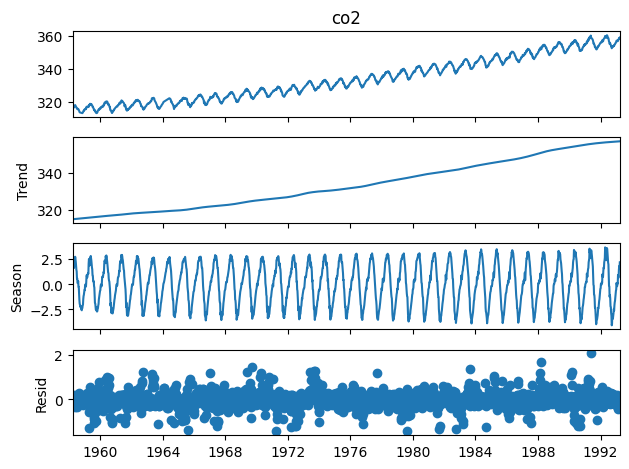

In [ ]:
# y: pd.Series with DatetimeIndex and a fixed frequency
m = 52
stl = sm.tsa.STL(y_train, period=m, robust=True)
res1 = stl.fit()
res1.plot()
plt.show()

In [34]:
# y_t = np.log(y)     # optional; use if seasonal amplitude grows with level
y_diff = y_train.diff(1).diff(m).dropna()

In [ ]:
# 3) Stationarity test: ADF (H0: unit root -> non-stationary)
from statsmodels.tsa.stattools import adfuller
adf_stat, pval, *_ = adfuller(y_diff, autolag="AIC") 
# autolag="AIC" chooses k to make residuals closer to white noise while avoiding too many lags，not the differencing order.
adf_stat, pval


(-14.044590430990345, 3.2578250992230353e-26)

residual is stationary. Then we apply ACF and PACF.

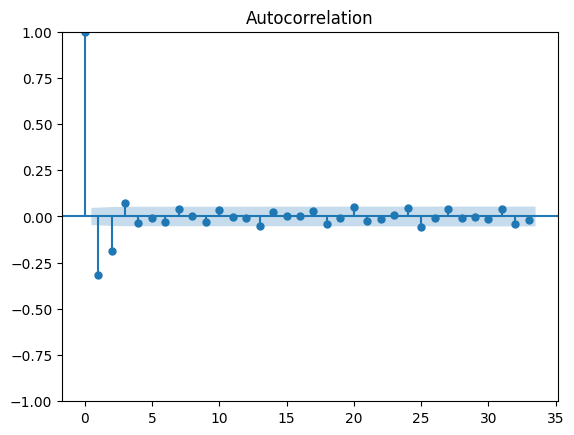

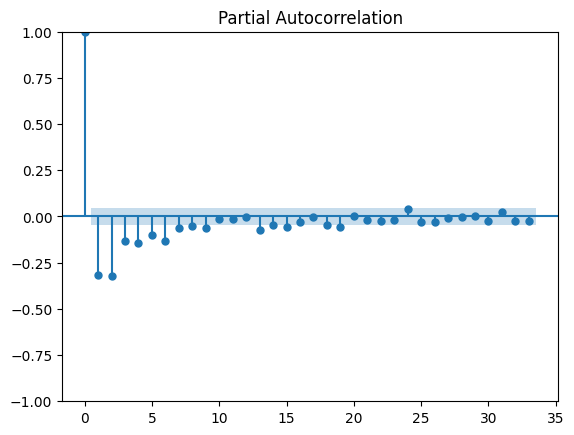

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y_diff)
plt.show()
plot_pacf(y_diff)
plt.show()

ACF plot: You have two clearly significant negative spikes at lag 1 and lag 2.

PACF plot: The first ~2 lags are the only ones that look clearly significant; the rest are small and gradually fade.

We'll try MA = 2, AR to be in (0,1,2)

If you only did y.diff(1) → use order=(p, 1, q) and seasonal_order=(P, 0, Q, m)

If you only did y.diff(m) → use order=(p, 0, q) and seasonal_order=(P, 1, Q, m)

If you did y.diff(1).diff(m) → use order=(p, 1, q) and seasonal_order=(P, 1, Q, m)

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

cands_p = [1, 2, 3, 4, 5, 6]
q = 2

rows = []
best = None

for p in cands_p:
    res1 = sm.tsa.SARIMAX(
        y_train,
        order=(p, 1, q),
        seasonal_order=(0, 1, 0, m),    # start simple; add seasonal MA/AR if needed
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)

    lb = acorr_ljungbox(res1.resid.dropna(), lags=[m], return_df=True)["lb_pvalue"].iloc[0]
    rows.append({"p": p, "q": q, "AIC": res1.aic, "LB_p(m)": lb, "n_iter": res1.nobs})

    if best is None or res1.aic < best[0]:
        best = (res1.aic, res1)

out = pd.DataFrame(rows).sort_values("AIC")
print(out.to_string(index=False))
best_res = best[1]
order = best_res.model.order
seasonal_order = best_res.model.seasonal_order
print("\nBest order:", order, "seasonal:", seasonal_order)

 p  q         AIC      LB_p(m)  n_iter
 4  2 2500.608205 1.168920e-57    1827
 6  2 2509.163784 2.545066e-56    1827
 5  2 2509.518079 1.358631e-56    1827
 3  2 2519.382927 1.387448e-55    1827
 2  2 2522.769568 4.623629e-57    1827
 1  2 2526.326681 7.115570e-56    1827

Best order: (4, 1, 2) seasonal: (0, 1, 0, 52)


Train MSE: 0.24316616225385584 RMSE: 0.49311881149866493
Train AIC: 2500.61 LB_p(52): 1.3960745077531154e-71
Test  MSE: 40.25388211794454 RMSE: 6.344594716602829


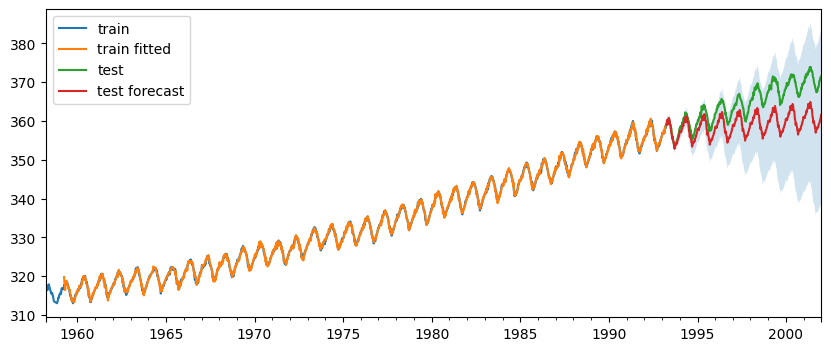

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

res1 = sm.tsa.SARIMAX(
    y_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(method='lbfgs', disp=False)

# --- training (in-sample) predictions ---
burn = m + 1
# burn the first seasonal period, which is usually called warmup period
yhat_train = res1.fittedvalues
train_mse = float(np.mean((y_train[burn:] - yhat_train[burn:]) ** 2))
train_rmse = float(np.sqrt(train_mse))
print("Train MSE:", train_mse, "RMSE:", train_rmse)

lb = acorr_ljungbox(res1.resid.dropna()[burn:], lags=[m], return_df=True)["lb_pvalue"].iloc[0]
# lags = [52] means a joint test for lags 1,2,3,...,52
# lags = 52 means a runnning test from 1 to 52
print("Train AIC:", round(res1.aic, 2), "LB_p(52):", float(lb))

# --- test forecast ---
fcst = res1.get_forecast(steps=len(y_test))
yhat_test = fcst.predicted_mean
ci = fcst.conf_int()

test_mse = float(np.mean((y_test - yhat_test) ** 2))
test_rmse = float(np.sqrt(test_mse))
print("Test  MSE:", test_mse, "RMSE:", test_rmse)

# --- plot: train + fitted + test + forecast ---
ax = y_train.plot(figsize=(10, 4), label="train")
yhat_train[burn:].plot(ax=ax, label="train fitted")
y_test.plot(ax=ax, label="test")
yhat_test.plot(ax=ax, label="test forecast")
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.2)
ax.legend()
plt.show()

white noise test doesn't pass, and test error is big. This means there are still autocorrelation that we didn't figure.

We can try:
- adding trend = 'c' or 'linear'
- adding MA = 1 in the seasonal order

Train MSE: 0.1451844601216264 RMSE: 0.381030786317361
Train AIC: 1532.02 LB_p(52): 0.09959580875619803
Test  MSE: 6.774935460730009 RMSE: 2.602870619283642


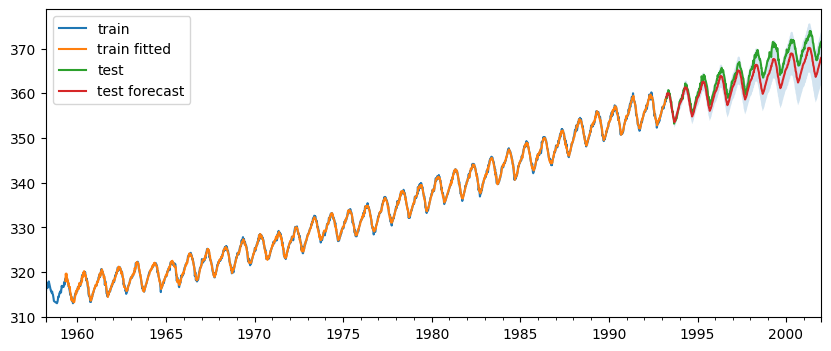

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

res1 = sm.tsa.SARIMAX(
    y_train,
    order=order,
    seasonal_order=(0, 1, 1, 52), # <- add Q=1
    # trend="c",  # constant trend
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(method='lbfgs', disp=False)

# --- training (in-sample) predictions ---
burn = m + 5 # not sure why it's 5, but otherwise it has some spike in the warmup period
# burn the first seasonal period, which is usually called warmup period
yhat_train = res1.fittedvalues
train_mse = float(np.mean((y_train[burn:] - yhat_train[burn:]) ** 2))
train_rmse = float(np.sqrt(train_mse))
print("Train MSE:", train_mse, "RMSE:", train_rmse)

lb = acorr_ljungbox(res1.resid.dropna()[burn:], lags=[m], return_df=True)["lb_pvalue"].iloc[0]
# lags = [52] means a joint test for lags 1,2,3,...,52
# lags = 52 means a runnning test from 1 to 52
print("Train AIC:", round(res1.aic, 2), "LB_p(52):", float(lb))

# --- test forecast ---
fcst = res1.get_forecast(steps=len(y_test))
yhat_test = fcst.predicted_mean
ci = fcst.conf_int()

test_mse = float(np.mean((y_test - yhat_test) ** 2))
test_rmse = float(np.sqrt(test_mse))
print("Test  MSE:", test_mse, "RMSE:", test_rmse)

# --- plot: train + fitted + test + forecast ---
ax = y_train.plot(figsize=(10, 4), label="train")
yhat_train[burn:].plot(ax=ax, label="train fitted")
y_test.plot(ax=ax, label="test")
yhat_test.plot(ax=ax, label="test forecast")
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.2)
ax.legend()
plt.show()

white noise test passed, and test error reduced significanlty